# Homework: Advanced Data Storage and Retrieval
### By: Ryan Zimmerlee
### Date: 4/1/2019

------------------------------------------------

# Surfs Up!

![surfs-up.jpeg](Images/surfs-up.jpeg)

Congratulations! You've decided to treat yourself to a long holiday vacation in Honolulu, Hawaii! To help with your trip planning, you need to do some climate analysis on the area. The following outlines what you need to do.

## Step 1 - Climate Analysis and Exploration

To begin, use Python and SQLAlchemy to do basic climate analysis and data exploration of your climate database. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

* Use the provided [starter notebook](climate_starter.ipynb) and [hawaii.sqlite](Resources/hawaii.sqlite) files to complete your climate analysis and data exploration.

* Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

* Use SQLAlchemy `create_engine` to connect to your sqlite database.

* Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.

### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Sort the DataFrame values by `date`.

* Plot the results using the DataFrame `plot` method.

* Use Pandas to print the summary statistics for the precipitation data.

### Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order.

  * Which station has the highest number of observations?

  * Hint: You may need to use functions such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.


## Step 2 - Climate App

Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.

* Use FLASK to create your routes.

### Routes

* `/`

  * Home page.

  * List all routes that are available.

* `/api/v1.0/precipitation`

  * Convert the query results to a Dictionary using `date` as the key and `prcp` as the value.

  * Return the JSON representation of your dictionary.

* `/api/v1.0/stations`

  * Return a JSON list of stations from the dataset.

* `/api/v1.0/tobs`
  * query for the dates and temperature observations from a year from the last data point.
  * Return a JSON list of Temperature Observations (tobs) for the previous year.

* `/api/v1.0/<start>` and `/api/v1.0/<start>/<end>`

  * Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

  * When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

  * When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

## Hints

* You will need to join the station and measurement tables for some of the analysis queries.

* Use Flask `jsonify` to convert your API data into a valid JSON response object.




# <font color='red'>My work starts here!</font>
----------------------------------------------------------------------------

# Step 1: Climate Analysis and Exploration using Reflection Tables and SQLAlchemy ORM

In [1]:
# Import Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

In [2]:
# Import Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# Create our engine, connecting it to the assigned sqlite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
# It found the measurement and station classes...which we can view the individual CSVs of
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

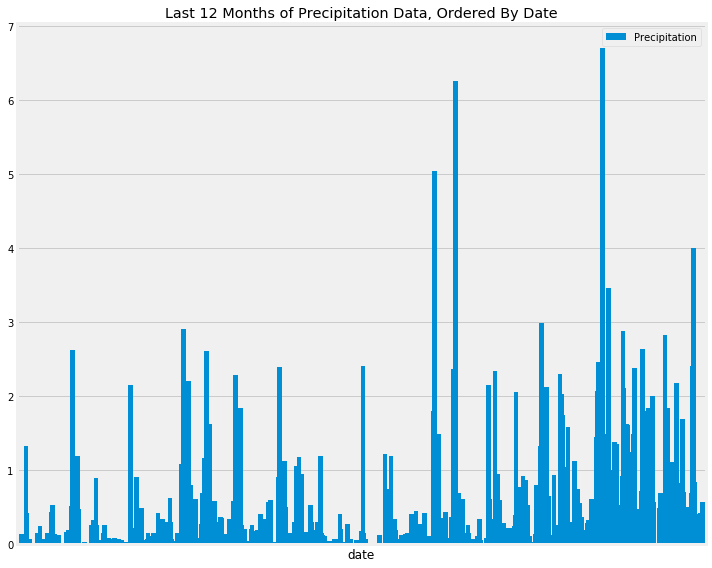

In [9]:
# Import additiona library rcParams for setting plot size
from pylab import rcParams

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = session.query(func.max(Measurement.date)).scalar()
# What does .scalar() really do?  Is this allowing me to grab and view one value since I'm using func.max?
# Would this allow me to grab an entire column?

# Find one year time delta from the last date in the SQL Measurement table
meas_dates = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date = datetime.strptime(meas_dates[0], "%Y-%m-%d")
oneYear = max_date - timedelta(days=365)

# Design and perform a query to retrieve the last 12 months of precipitation data and plot the results
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > oneYear).all()
precip

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip, columns=['date','prcp'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df.sort_values(by=['date'],ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar(width=15, label = "Precipitation")

# Rename precipitation field from 'prcp' to 'Precipitation'
L=plt.legend()
L.get_texts()[0].set_text('Precipitation')

# Remove label ticks because 365 days of dates looked FUNKY - lemme tell ya!
plt.xticks([])

# Give the graph a title
plt.title("Last 12 Months of Precipitation Data, Ordered By Date")

# Using rcParams, configure the plot size
rcParams['figure.figsize'] = 10, 8

# Show the visualization...not entirely sure if this is needed as it still shows when commented out
plt.tight_layout()
plt.show()

# Whenever I run this cell for the first time after opening the notebook or restarting the kernel, it comes out small! 
# ... re-run this cell for the true img size to show...

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset
station_list = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {station_list} different stations in the dataset.")

There are 9 different stations in the dataset.


In [12]:
# From SQLAlchemy, import desc to quickly order my output in descending order
from sqlalchemy import desc

# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(desc(func.count(Measurement.station))).all()

# View the output of my query
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature from the most active station
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
active_station_stats = session.query(*sel).filter(Measurement.station == "USC00519281").all()
active_station_stats

[(54.0, 85.0, 71.66378066378067)]

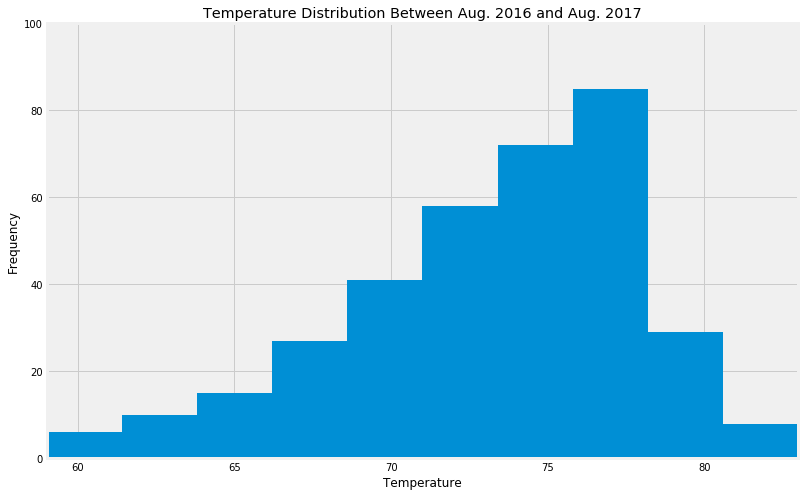

In [15]:
# Choose the station with the highest number of temperature observations.
# That would be USC00519281, as seen above.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Hard coded my date...probably better way to do this
temp = session.query(Measurement.tobs)\
        .filter(Measurement.date > oneYear)\
        .filter(Measurement.station == "USC00519281").all()

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.DataFrame(temp, columns=['Temp'])
temp_df

# Use Matplotlib to plot the data
# Assigning underscore dummy variable in front of my plot to hide the three arrays
_ = plt.hist(temp_df['Temp'])

# Configuring the histogram
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Distribution Between Aug. 2016 and Aug. 2017")
plt.ylim(0, 100)
plt.xlim(59,83)
rcParams['figure.figsize'] = 12,8
plt.show()


In [16]:
# Using 'Help' on Matplotlib histogram to look at parameters
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, hold=None, data=None, **kwargs)
    Plot a histogram.
    
    Compute and draw the histogram of *x*. The return value is a
    tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
    [*patches0*, *patches1*,...]) if the input contains multiple
    data.
    
    Multiple data can be provided via *x* as a list of datasets
    of potentially different length ([*x0*, *x1*, ...]), or as
    a 2-D ndarray in which each column is a dataset.  Note that
    the ndarray form is transposed relative to the list form.
    
    Masked arrays are not supported at present.
    
    Parameters
    ----------
    x : (n,) array or sequence of (n,) arrays
        Input values, this takes either a single array or a sequence of


In [17]:
# This code was provided as an example:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# I want my trip to be the day after class ends - July 9th, 2019 through July 20th, 2019.
# Since we do not have 2018 data, I will use 2017 data for those dates.
print(calc_temps('2017-07-09', '2017-07-20'))

[(69.0, 78.43589743589743, 83.0)]


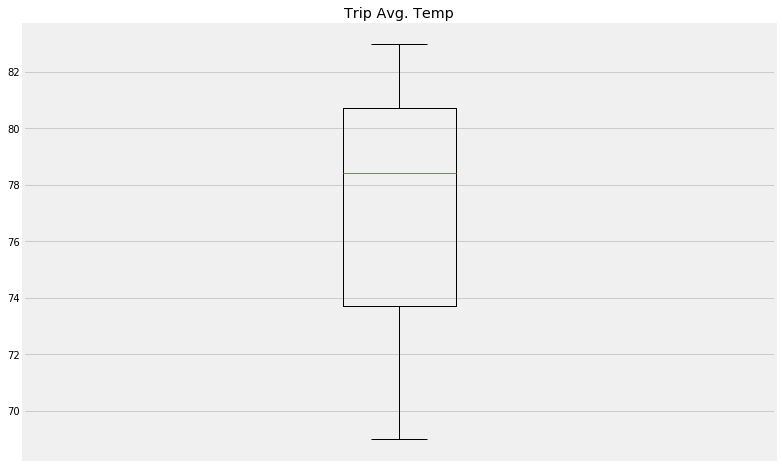

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Using the above function, I'm plugging in my "planned" trip dates to Hawaii
vacation_temp_list = calc_temps('2017-07-09', '2017-07-20')
vacation_temp_list

# Create a dataframe with the above output
vacation_temp_df = pd.DataFrame(vacation_temp_list, columns=['Min','Avg.','Max'])
vacation_temp_df

# Create bar chart fields
n = 1
min = vacation_temp_df['Min']
max = vacation_temp_df['Max']
avg = vacation_temp_df['Avg.']

# Calculate variances from average for yerr 
pos_std = (max-avg)
neg_std = (min-avg)

# I think this originally called for a bar chart, but a boxplot is much more effective here.  I tested the "yerr" - the 
# original thing they wanted us to use on the bar chart...meh, this looks better in my opinion.
plt.boxplot(vacation_temp_df)
plt.title("Trip Avg. Temp")
rcParams['figure.figsize'] = 4, 8
plt.xlim(0.5,1.5)
plt.xticks([])
plt.show()

# Same thing here...run this again for the true img formatting to appear...

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Query the data for the previous year's vacation dates
rain_count = session.query(Measurement.station, func.sum(Measurement.prcp)).\
filter(Measurement.date > '2017-07-08').\
filter(Measurement.date < '2017-07-21').\
group_by(Measurement.station).\
order_by(desc(func.sum(Measurement.prcp))).all()
rain_count

# Create a dataframe with the results
rain_df = pd.DataFrame(rain_count, columns =('Station','Precipitation'))
rain_df

# Similarly, query the data for each station, which includes the lat, long, station name and elevation
station_data = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_data

# Create another dataframe with the station results
station_df = pd.DataFrame(station_data, columns=('Station','Station Name','Latitude','Longitude','Elevation'))
station_df

# Merge and sort the two dataframes on 'Station', sorting by the precipitation amount
merged_df = pd.merge(station_df, rain_df, how='inner', on='Station',
         left_index=False, right_index=False, sort=True)
sorted_merged_df = merged_df.sort_values(by=['Precipitation'], ascending=False)
sorted_merged_df



,Station,Station Name,Latitude,Longitude,Elevation,Precipitation
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.79
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.47
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.86
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.70
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.44
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.22
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


# Part 2: Using Flask to Create Routes to View JSON Data

#### This is also all found in my 'Hawaii.sqlite' python file.

In [27]:
# Import my dependencies
import numpy as np
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify
import datetime as dt
from datetime import datetime, timedelta

# Create our engine, connecting it to the assigned sqlite database
engine = create_engine("sqlite:///hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Setup Flask
app = Flask(__name__)

# Establish routes
# Provide in-line HTML formatting to make the page look prettier
@app.route("/")
def welcome():

    return (
        # Assignment and creator info
        f"<h4>Hawaii Climate Info <br>"
        f"By: Ryan Zimmerlee<br>"
        f"Date: 04/02/2019<br><br><br>"
        f"Below are the available routes and Hawaii climate information: </h4> <br>"

        # Precipitation page
        f"<b>Precipitation by day for the last year:</b><br>"
        f"/api/v1.0/precipitation<br><br>"

        # Weather station page
        f"<b>All Hawaii weather stations:</b><br>"
        f"/api/v1.0/stations<br><br>"

        # Temperature page
        f"<b>Temperature by day for the last year:</b><br>"
        f"/api/v1.0/tobs<br><br>"

        # Min, max, avg temp page - by start date
        f"<b>The below route will give you the min, max and average temperature values for all dates greater than the date provided: </b><br>"
        f"<b>Please provide a start date after the backslash using the following format: .../api/v1.0/YYYY-MM-DD/ </b><br>"
        f"/api/v1.0/<start_date><br><br>"

        # Min, max, avg temp page - by start and end date
        f"<b>The below route will give you the min, max and average temperature values for the provided date range. </b><br>"
        f"<b>Please provide a start date and an end date after the backslash using the following format: .../api/v1.0/YYYY-MM-DD/YYYY-MM-DD </b><br>"
        f"/api/v1.0/<start_date>/<end_date>"
    )

# Precipitation route
@app.route("/api/v1.0/precipitation")
def precips():
    # Start the session for the page
    session = Session(engine)

    # Find one year time delta from the last date in the SQL Measurement table
    meas_dates = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
    max_date = datetime.strptime(meas_dates[0], "%Y-%m-%d")
    oneYear = max_date - timedelta(days=365)

    precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > oneYear).all()

    # Convert list of tuples into normal list
    precip_lastyear = list(np.ravel(precip))

    # JSONIFY the object
    return jsonify(precip_lastyear)

# Stations route
@app.route("/api/v1.0/stations")
def stations():
    # Start the session for the page
    session = Session(engine)

    # Query Station sqlite and get all station names 
    station_names = session.query(Station.name).all()
    
    # Convert list of tuples into normal list
    all_stations = list(np.ravel(station_names))

    # JSONIFY the list of tuples
    return jsonify(all_stations)

# Temperature route
@app.route("/api/v1.0/tobs")
def temps():
    # Start the session for the page
    session = Session(engine)

    # Find one year time delta from the last date in the SQL Measurement table
    meas_dates = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
    max_date = datetime.strptime(meas_dates[0], "%Y-%m-%d")
    oneYear = max_date - timedelta(days=365)

    # Query Measurement sqlite to get the date and temperature
    temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > oneYear).order_by(Measurement.date).all()

    # Create a list of a collection of dictionaries that extracts the data we want from the object
    temps_lastyear = []
    for date, tobs in temps:
        temp_dict = {}
        temp_dict["date"] = date
        temp_dict["tobs"] = tobs
        temps_lastyear.append(temp_dict)

    # JSONIFY the list
    return jsonify(temps_lastyear)

# Start date only route
@app.route("/api/v1.0/<start_date>")
def startDate(start_date):
    # Start the session for the page
    session = Session(engine)

    # Query Measurement sqlite to get the min, max and avg result for the selected date ranges 
    start_date = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).all()

    # JSONIFY the object
    return jsonify(start_date)

# Start and end date route
@app.route("/api/v1.0/<start_date>/<end_date>")
def startAndEndDate(start_date, end_date):
    # Start the session for the page
    session = Session(engine)

    # Query Measurement sqlite to get the min, max and avg result for the selected date ranges    
    start_and_end_date = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

    # JSONIFY the object
    return jsonify(start_and_end_date)

# Allow for page debugging / log
if __name__ == '__main__':
    app.run(debug=True)